In [41]:
from my_vars import get_warning_list
# Trueになっている警報・注意報のリスト
warn_files = get_warning_list()
for warn_name,is_active in warn_files.items():
    if is_active:
        print(warn_name)

雷注意報
大雨注意報
洪水注意報
強風注意報
大雨警報
洪水警報
暴風警報
大雨特別警報


In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import warnings
import pickle
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')

# 各1時間ステップにおける警報発令割合を計算
def calculate_alert_ratio(start_time, end_time, alerts):
    total_seconds = 3600
    alert_time = 0
    for _, row in alerts.iterrows():
        alert_start = max(row['開始日時'], start_time)
        alert_end = min(row['終了日時'], end_time)
        if alert_start < alert_end:
            alert_time += (alert_end - alert_start).total_seconds()
    return alert_time / total_seconds

# 統合結果を保存するデータフレーム
combined_df = pd.DataFrame()

# 警報ファイルの処理
for warn_name, is_active in warn_files.items():
    if is_active:
        print(warn_name)
        # CSVデータをデータフレームに読み込む
        url_html = f'./kurashiki/output/{warn_name}_filtered_alerts.csv'
        df = pd.read_csv(url_html)

        # 列名を設定
        df.columns = ['ID', '警報', '県', '開始日時', '終了日時', '期間']

        # 文字列をdatetimeに変換
        date_format = '%Y-%m-%d %H:%M'
        df['開始日時'] = pd.to_datetime(df['開始日時'].str[:16], format=date_format)
        df['終了日時'] = pd.to_datetime(df['終了日時'].str[:16], format=date_format)

        # 全期間をカバーする日時範囲を取得
        start_time = df['開始日時'].iloc[0]
        end_time = df['終了日時'].iloc[-1]

        # 各1時間ステップのdatetimeリストを作成
        time_range = pd.date_range(start=start_time, end=end_time, freq='H')

        # 結果を保存するデータフレームを作成
        result_df = pd.DataFrame(time_range, columns=['time'])

        # 各1時間ステップの時間範囲に基づく比率を計算
        result_df['ratio'] = result_df.apply(lambda row: calculate_alert_ratio(row['time'], row['time'] + timedelta(hours=1), df), axis=1)

        # float型に変換
        result_df['ratio'] = result_df['ratio'].astype(float)

        # 'time' 列をdatetime型にしてインデックスに設定し、時：分：秒が00:00:00となるように調整
        result_df['time'] = result_df['time'].dt.floor('H')
        result_df.set_index('time', inplace=True)

        # 2016年以降のデータのみを抽出
        start_date = datetime(2016, 1, 1)
        filtered_df = result_df[result_df.index >= start_date]

        # 警報名で列名を変更
        filtered_df.rename(columns={'ratio': warn_name}, inplace=True)

        # 統合
        if combined_df.empty:
            combined_df = filtered_df
        else:
            combined_df = combined_df.join(filtered_df, how='outer')

# NaNを0で埋める
combined_df.fillna(0, inplace=True)

# 結果を表示
print(combined_df)

# pickleで保存（書き出し）
pickle_path = './kurashiki/output/warning_list.pickle'
with open(pickle_path, mode='wb') as fo:
    pickle.dump({'combined_df': combined_df}, fo)



# 以下，グラフ表示のみ，単体で実行可

                     雷注意報  大雨注意報  洪水注意報  強風注意報  大雨警報  洪水警報  暴風警報  大雨特別警報
time                                                                    
2016-01-01 00:00:00   0.0    0.0    0.0    0.0   0.0   0.0   0.0     0.0
2016-01-01 01:00:00   0.0    0.0    0.0    0.0   0.0   0.0   0.0     0.0
2016-01-01 02:00:00   0.0    0.0    0.0    0.0   0.0   0.0   0.0     0.0
2016-01-01 03:00:00   0.0    0.0    0.0    0.0   0.0   0.0   0.0     0.0
2016-01-01 04:00:00   0.0    0.0    0.0    0.0   0.0   0.0   0.0     0.0
...                   ...    ...    ...    ...   ...   ...   ...     ...
2024-09-13 16:00:00   1.0    0.0    0.0    0.0   0.0   0.0   0.0     0.0
2024-09-13 17:00:00   1.0    0.0    0.0    0.0   0.0   0.0   0.0     0.0
2024-09-13 18:00:00   1.0    0.0    0.0    0.0   0.0   0.0   0.0     0.0
2024-09-13 19:00:00   1.0    0.0    0.0    0.0   0.0   0.0   0.0     0.0
2024-09-13 20:00:00   0.3    0.0    0.0    0.0   0.0   0.0   0.0     0.0

[76293 rows x 8 columns]


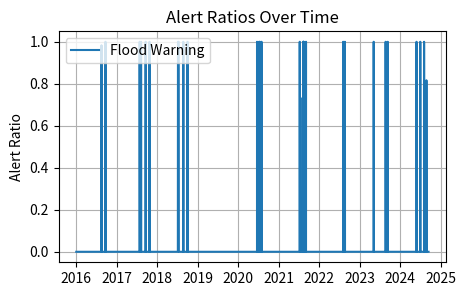

In [9]:
import warnings
import pickle
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')

# # 日本語フォントを可能にするアイテム
from matplotlib import rcParams
rcParams['font.family'] = 'Noto Sans CJK JP'

# pickleで保存したファイルを読み込み
pickle_path = './kurashiki/output/warning_list.pickle'
with open(pickle_path, mode='rb') as fi:
    data = pickle.load(fi)

loaded_combined_df = data['combined_df']
print(loaded_combined_df)

show_graph=loaded_combined_df['洪水警報']

# グラフを描画
plt.figure(figsize=(5, 3))
plt.plot(show_graph)
# plt.xlabel('Time')
plt.ylabel('Alert Ratio')
plt.title('Alert Ratios Over Time')

# 凡例を追加（リストとして渡す）
# plt.legend([show_graph.name], loc='upper left')
# English ver
plt.legend(['Flood Warning'], loc='upper left')
plt.grid()

# グラフを表示
plt.show()